# EECS 731 Project 5 - Time Series

The goal of this project was to use time series analysis on [this Kaggle Product Demand Dataset](https://www.kaggle.com/felixzhao/productdemandforecasting) to predict the order demand for a given product on a given day. To this end, I looked at a few products that I picked at random and used both Facebook's Prophet and gradient boosting through XGBoost.

In [1]:
%matplotlib inline

import numpy as np
import pandas
from tqdm.notebook import tqdm

tqdm.pandas()

/home/grant/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Initial looks and cleaning of the data

As you can see, the raw data has the date in a string format (Pandas didn't automatically convert it to a datetime), the product, the warehouse, the category, and the given demand on that day. For this project, since we only want to forecast one product at a time, the only features we'll be using is the date and the order demand.

In [2]:
raw_data = pandas.read_csv("../data/Historical_Product_Demand.csv")

raw_data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [3]:
raw_data.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


## Converting the date

First things first, we need the date to be in something that's easier to work with such as a datetime object, luckily Pandas can do this essentially automatically.

In [4]:
raw_data['Date'] = pandas.to_datetime(raw_data['Date'])
raw_data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


## Cleaning Order Demand

Although not present in the sample above, some Order_Demand fields have their numbers wrapped in parentheses, which I took to be the accounting representation of a negative number (e.g. (100) is -100)). So, here we convert from that form into a python float.

In [5]:
def accounting_to_float(row):
    if row['Order_Demand'][0] == "(":
        return -float(row['Order_Demand'][1:-1])
    else:
        return float(row['Order_Demand'])

raw_data['y'] = raw_data.progress_apply(accounting_to_float, axis=1)

raw_data.y.describe()

count    1.048575e+06
mean     4.867427e+03
std      2.893346e+04
min     -9.990000e+05
25%      1.800000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: y, dtype: float64

## Cleaning Dates

Some dates seemed to have been malformed and thus we'll remove all dates that occur before an arbitrary time that's well before the start of this dataset.

In [6]:
raw_data = raw_data.sort_values('Date', ascending=True)
raw_data = raw_data.loc[raw_data.Date > pandas.to_datetime("1960-01-01")]

# Product Predictions

For each product I tested, you will first see a plot of what the historical demand looked like and then the trial runs for both Prophet and XGBoost. Instead of repeating myself at each run, I'll describe what's going on overall here. I used mean squared error as an accuracy measure, although this isn't great due to the sometimes large outliers in the data, it's useful for comparing between the two models since they're dealing with the same outliers. For Prohpet I used it's builtin plotting function to plot both the historical data that specific model was trained on as well as it's prediction for the rest of the dataset. It's interesting to watch how it gets more accuracte with each fold of the Time Series Split. 

In general Prophet performs better than XGBoost, which makes sense as it's purpose designed for time series while XGBoost is essentially learning the same decomposition that Prophet already has programmed in.

## Product 2054

The first product I tried was `Product_2054` I have no clue what it is, but it has realively low and consistent demand so it seemed like a good starting point.

In [7]:
mask = raw_data['Product_Code'] == 'Product_2054'
raw_data.loc[mask]['Date'].describe()

/home/grant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                     335
unique                    273
top       2013-10-25 00:00:00
freq                        5
first     2012-01-09 00:00:00
last      2016-12-16 00:00:00
Name: Date, dtype: object

/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


,ds,y
121833,2012-01-09,10.0
66692,2012-01-12,30.0
123014,2012-01-12,35.0
119827,2012-01-13,70.0
122517,2012-02-02,4.0


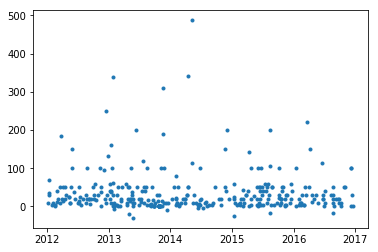

In [8]:
from matplotlib import pyplot as plt

data = raw_data.loc[mask]
df = pandas.DataFrame()

df['ds'] = data['Date']
df['y'] = data['y']

df = df.dropna()

plt.plot(df['ds'], df['y'], '.')

df.head()

In [9]:
df.y.describe()

count    335.000000
mean      35.220896
std       55.226145
min      -30.000000
25%        5.000000
50%       20.000000
75%       42.000000
max      487.000000
Name: y, dtype: float64

## Prophet

Importing plotly failed. Interactive plots will not work.


mse: 270877.4492348093
mse: 5668.528225040777
mse: 3328.9630200440574
mse: 6272.879844607437
mse: 13298.205273546166
mse: 3310.0742742932216
mse: 1364.4308272248347
mse: 2006.2256285256474
mse: 3000.2661966026794
mse: 905.9369036447725


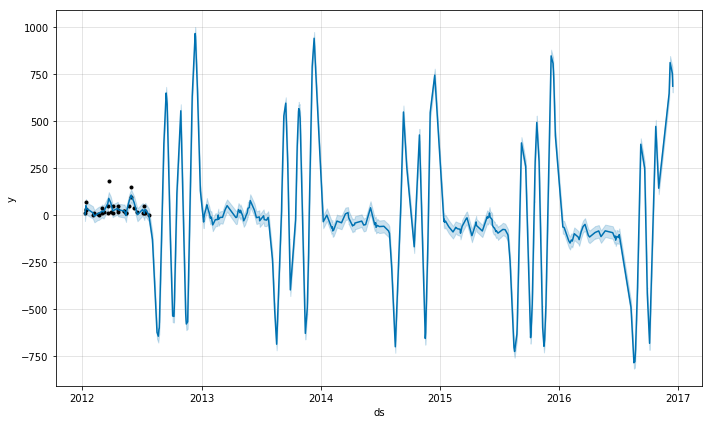

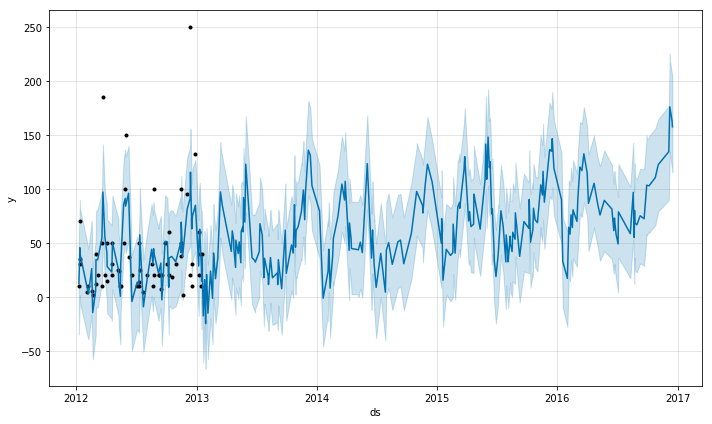

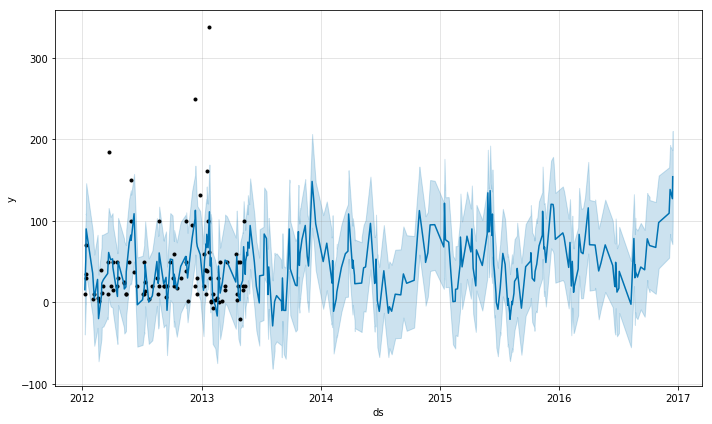

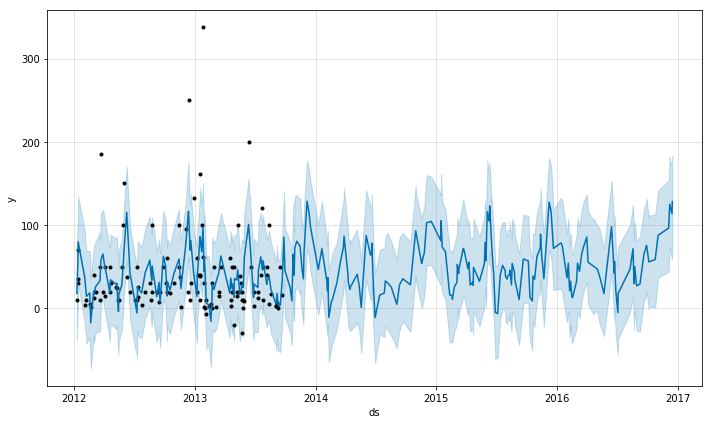

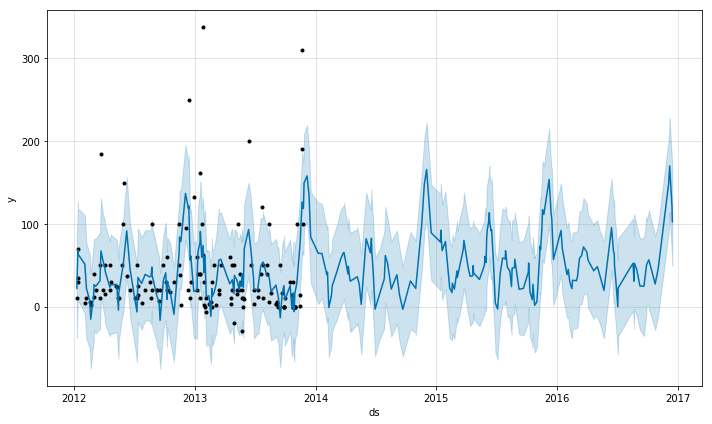

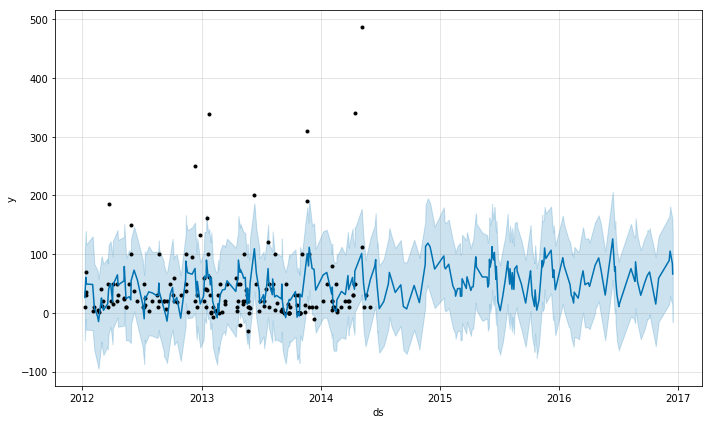

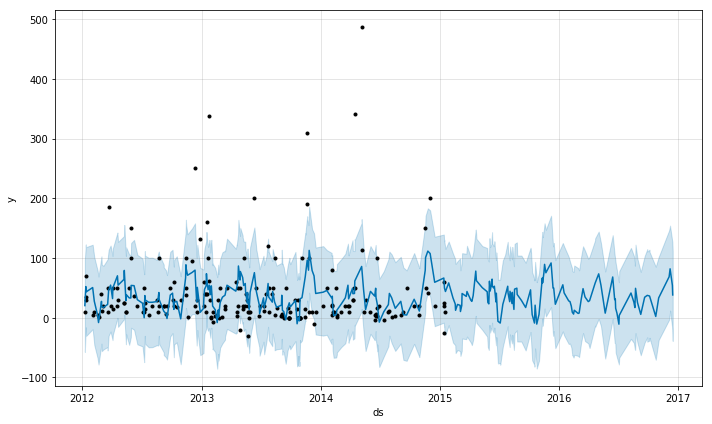

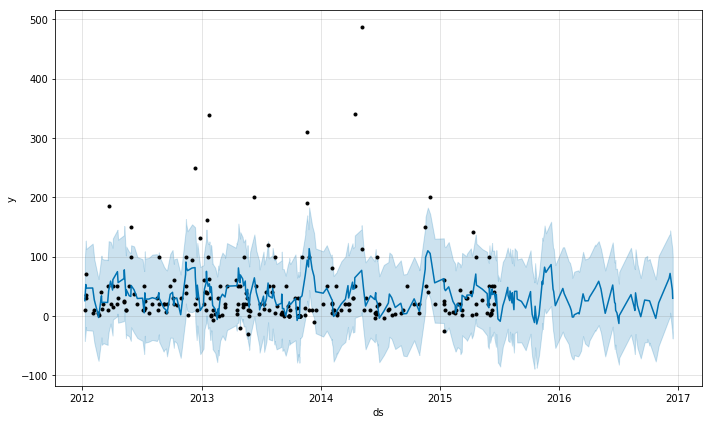

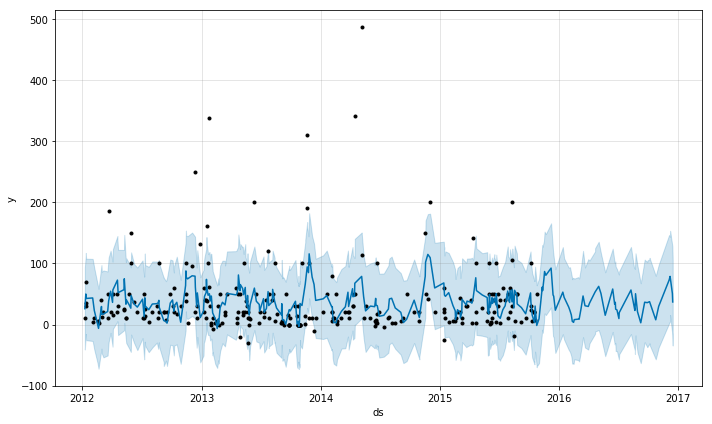

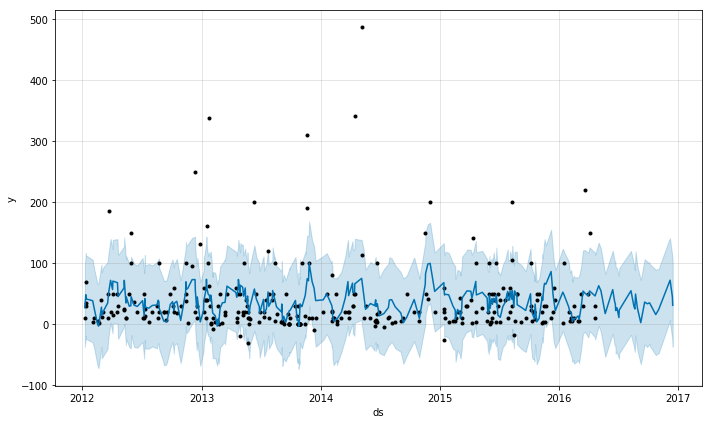

In [10]:
from fbprophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')

tscv = TimeSeriesSplit(n_splits=10)
ds = np.array(df.ds.tolist())
y = np.array(df.y.tolist())
for train_idx, test_idx in tscv.split(ds):
    m = Prophet(yearly_seasonality=True, daily_seasonality=True)
    input_df = pandas.DataFrame()
    input_df['ds'] = ds[train_idx]
    input_df['y'] = y[train_idx]
    m.fit(input_df)
    future = pandas.DataFrame()
    future['ds'] = ds
    forecast = m.predict(future)
    m.plot(forecast)
    print(f"mse: {mean_squared_error(forecast['yhat'][test_idx], y[test_idx])}")
warnings.simplefilter('default')

## Gradient Boosting

In [11]:
import xgboost
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter('ignore')

tscv = TimeSeriesSplit(n_splits=10)

weekday = df.apply(lambda r: r['ds'].weekday(), axis=1)
month = df.apply(lambda r: r['ds'].month, axis=1)
year = df.apply(lambda r: r['ds'].year, axis=1)

weekday = np.array(weekday).reshape(-1, 1)
X = np.append(weekday, np.array(month).reshape(-1, 1), 1)
X = np.append(X, np.array(year).reshape(-1, 1), 1)

y = np.array(df.y.tolist()).reshape(-1, 1)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]
    
    model = xgboost.XGBRegressor()
    model.fit(X_train, Y_train)
    
    Y_pred = model.predict(X_test)
    
    print(f"mse: {mean_squared_error(Y_test, Y_pred)}")
    
warnings.simplefilter('default')

/home/grant/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/grant/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/grant/anaconda3/lib/python3.7/site-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
/home/grant/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


mse: 2895.073685942136
mse: 4321.801330583691
mse: 3247.6357438683576
mse: 4555.841758989305
mse: 14980.384386564874
mse: 5108.919126008084
mse: 4243.315440474201
mse: 1799.2083810327497
mse: 9490.325015569859
mse: 3390.8588903914083


## Product 1560

/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


,ds,y
113970,2012-01-03,2950.0
113972,2012-01-04,0.0
111637,2012-01-04,2000.0
115146,2012-01-10,100.0
115149,2012-01-10,0.0


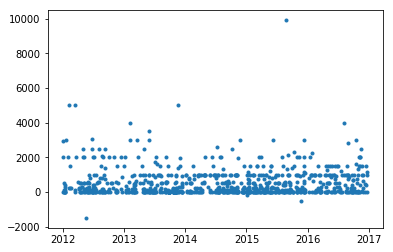

In [12]:
from matplotlib import pyplot as plt

mask = raw_data['Product_Code'] == 'Product_1560'

data = raw_data.loc[mask]
df = pandas.DataFrame()

df['ds'] = data['Date']
df['y'] = data['y']

plt.plot(df['ds'], df['y'], '.')

df.head()

## Prophet

mse: 140403583.48580235
mse: 831091.1260989769
mse: 424711.02627688687
mse: 809312.6943459053
mse: 461370.1802585449
mse: 468559.6470023946
mse: 422079.27481898543
mse: 1660801.3350738368
mse: 518873.17540200404
mse: 653930.120006257


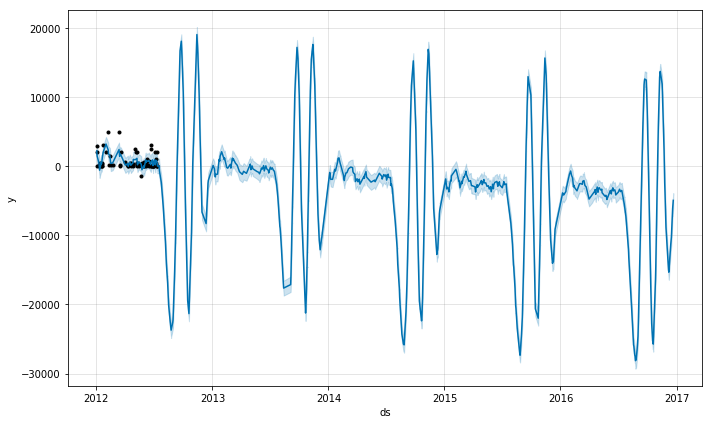

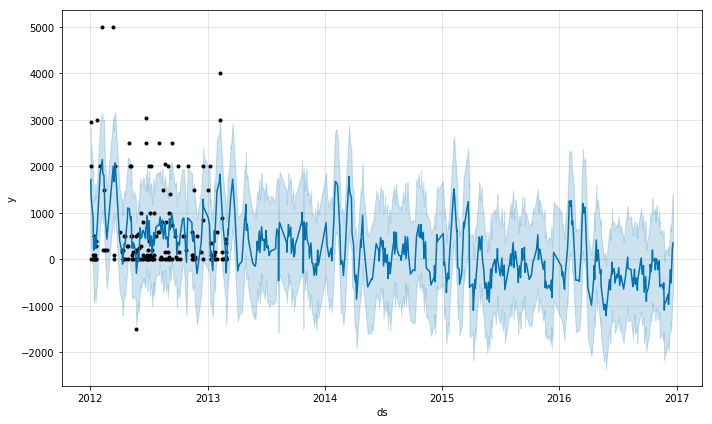

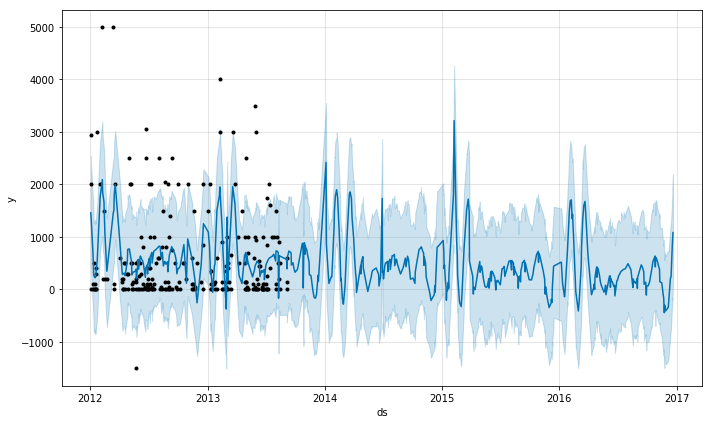

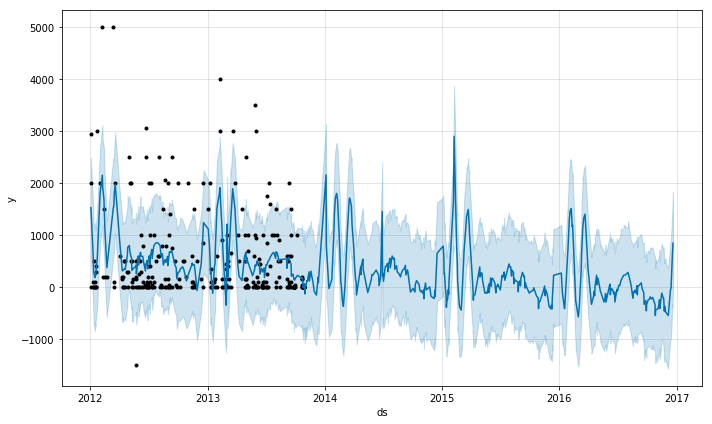

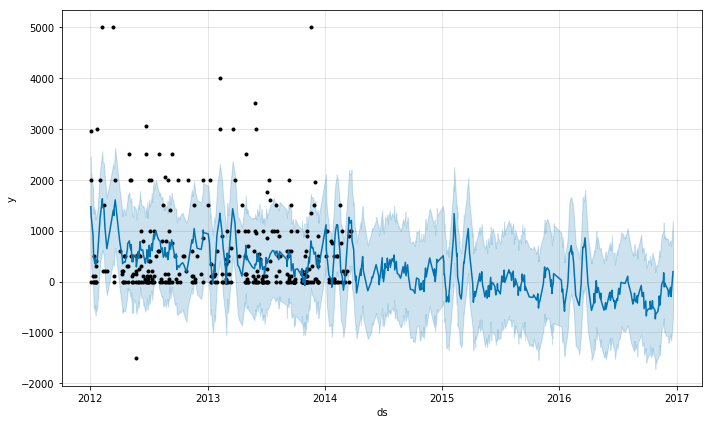

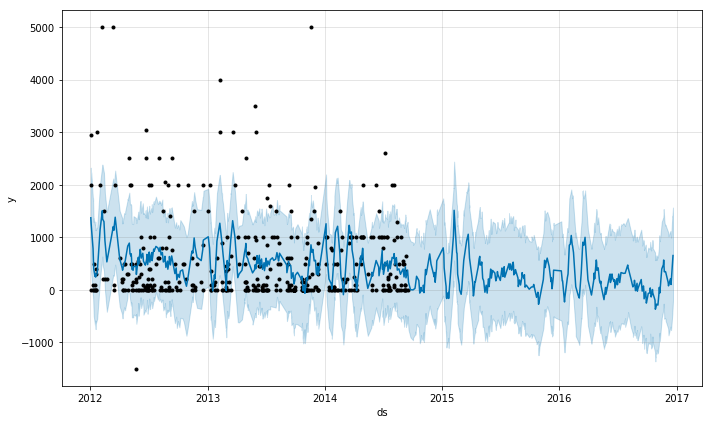

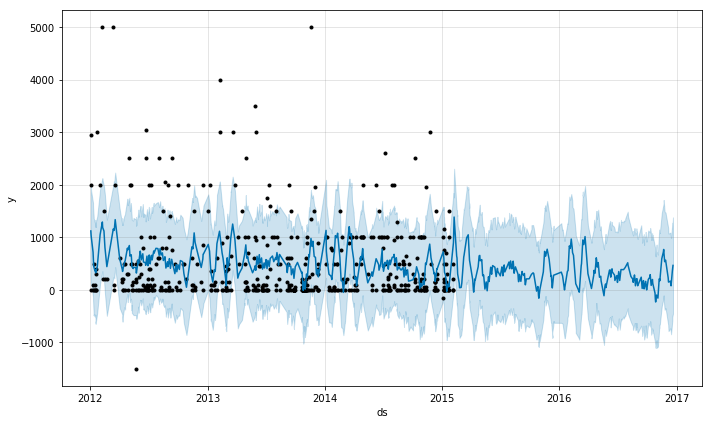

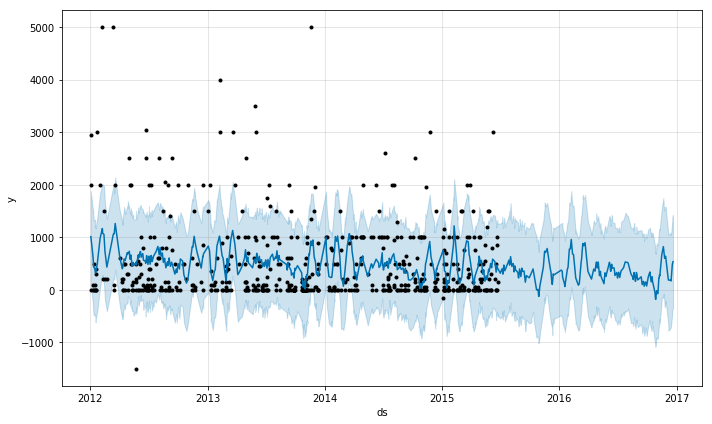

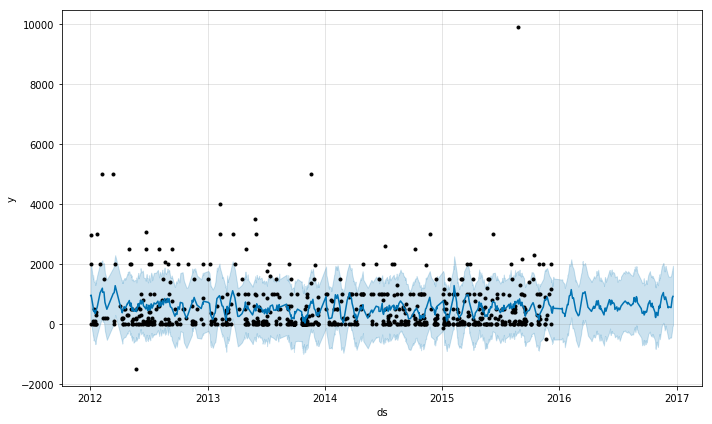

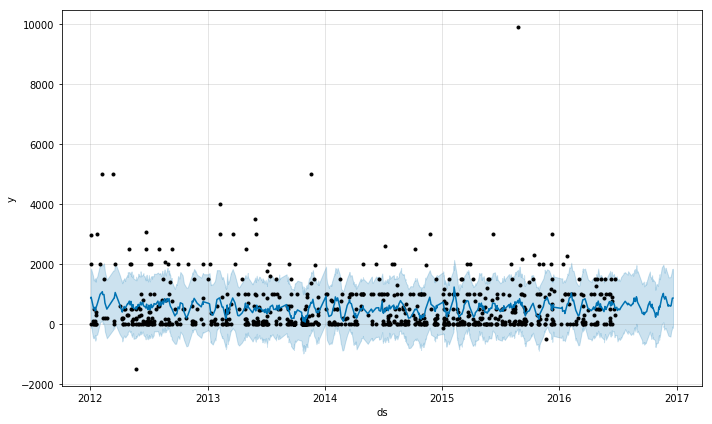

In [13]:
from fbprophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')

tscv = TimeSeriesSplit(n_splits=10)
ds = np.array(df.ds.tolist())
y = np.array(df.y.tolist())
for train_idx, test_idx in tscv.split(ds):
    m = Prophet(yearly_seasonality=True, daily_seasonality=True)
    input_df = pandas.DataFrame()
    input_df['ds'] = ds[train_idx]
    input_df['y'] = y[train_idx]
    m.fit(input_df)
    future = pandas.DataFrame()
    future['ds'] = ds
    forecast = m.predict(future)
    m.plot(forecast)
    print(f"mse: {mean_squared_error(forecast['yhat'][test_idx], y[test_idx])}")
warnings.simplefilter('default')

## Gradient Boosting

In [14]:
import xgboost
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter('ignore')

tscv = TimeSeriesSplit(n_splits=10)

weekday = df.apply(lambda r: r['ds'].weekday(), axis=1)
month = df.apply(lambda r: r['ds'].month, axis=1)
year = df.apply(lambda r: r['ds'].year, axis=1)

weekday = np.array(weekday).reshape(-1, 1)
X = np.append(weekday, np.array(month).reshape(-1, 1), 1)
X = np.append(X, np.array(year).reshape(-1, 1), 1)

y = np.array(df.y.tolist()).reshape(-1, 1)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]
    
    model = xgboost.XGBRegressor()
    model.fit(X_train, Y_train)
    
    Y_pred = model.predict(X_test)
    
    print(f"mse: {mean_squared_error(Y_test, Y_pred)}")
    
warnings.simplefilter('default')

mse: 1433888.6457611632
mse: 1450869.174022706
mse: 629507.8421810862
mse: 771266.9876303532
mse: 591717.2949123039
mse: 510843.1944985973
mse: 514681.6043802111
mse: 2038989.4163770454
mse: 598558.1063626328
mse: 1278347.6608205508


## Product 0130

/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/grant/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


,y
count,874.000000
mean,53.651030
std,78.428673
min,-73.000000
25%,10.000000
50%,23.000000
75%,70.000000
max,1000.000000


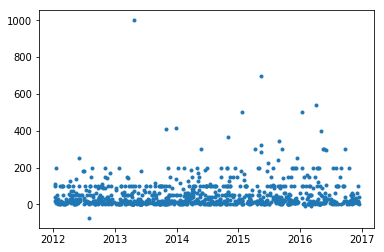

In [15]:
from matplotlib import pyplot as plt

mask = raw_data['Product_Code'] == 'Product_0130'

data = raw_data.loc[mask]
df = pandas.DataFrame()

df['ds'] = data['Date']
df['y'] = data['y']

plt.plot(df['ds'], df['y'], '.')

df.describe()

## Prophet

mse: 5451674.120958807
mse: 16136.201440868252
mse: 3640.2309303960305
mse: 6075.749904922307
mse: 3490.1011642158583
mse: 6961.107800291209
mse: 9910.496218312144
mse: 5695.567246938552
mse: 12082.275579305371
mse: 4865.574186593447


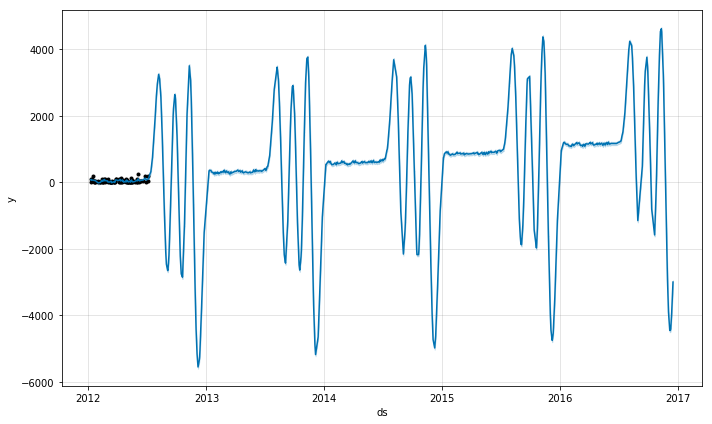

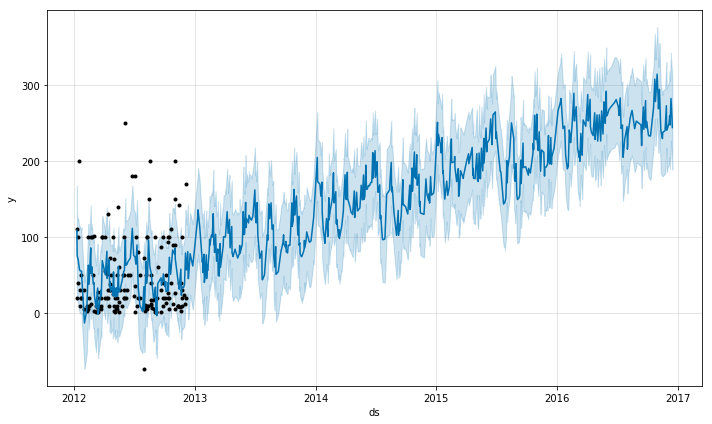

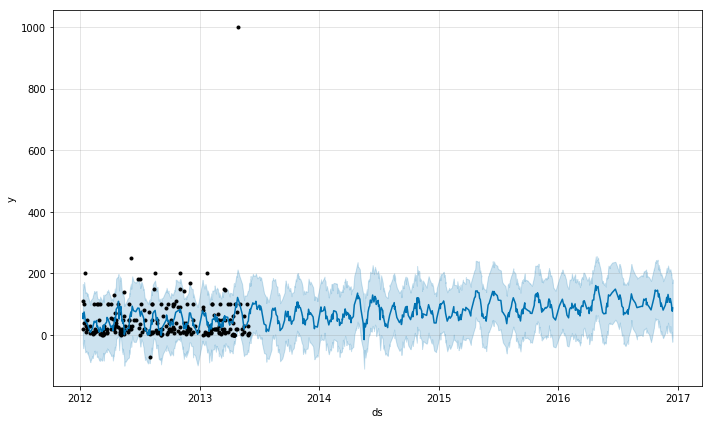

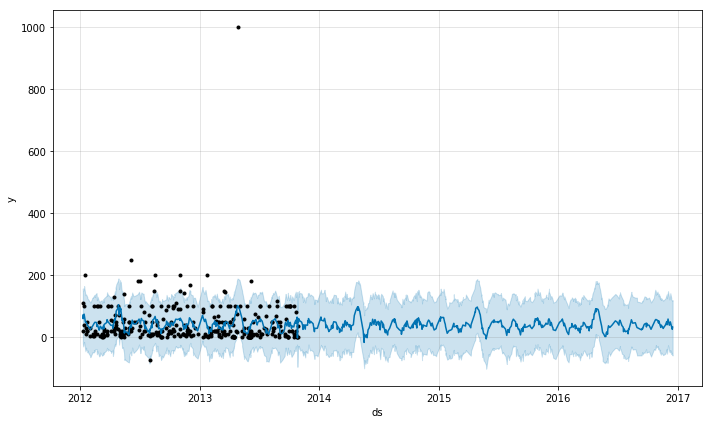

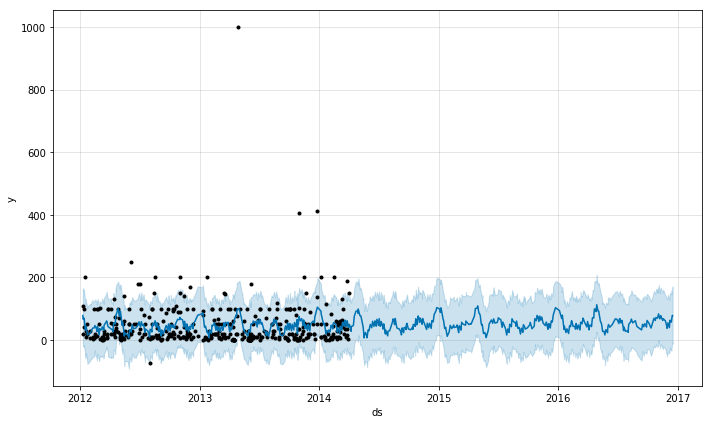

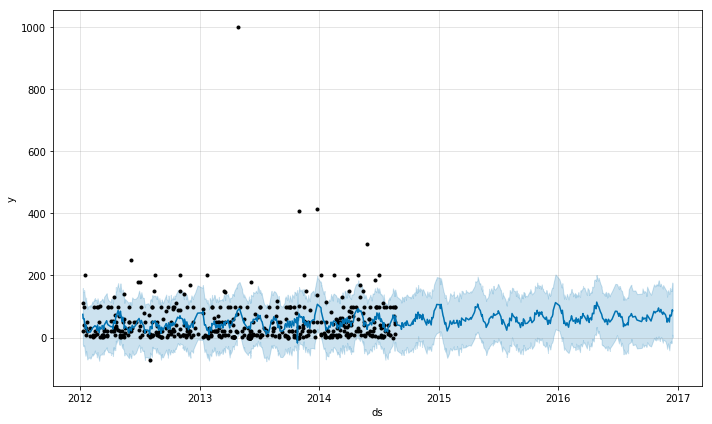

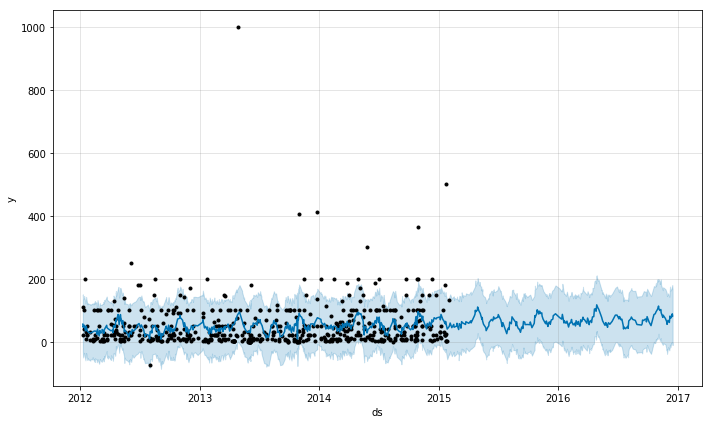

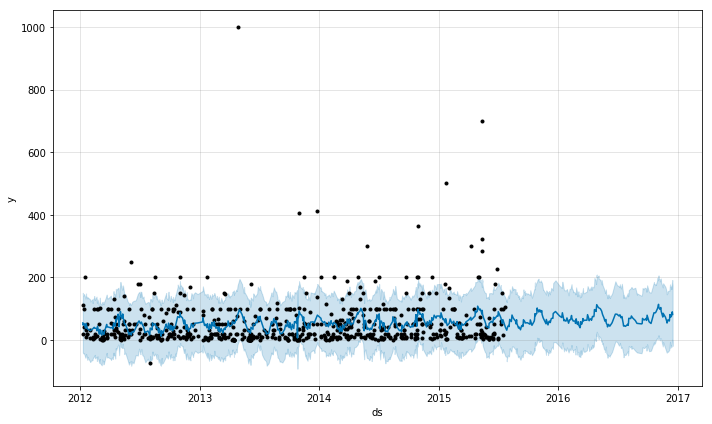

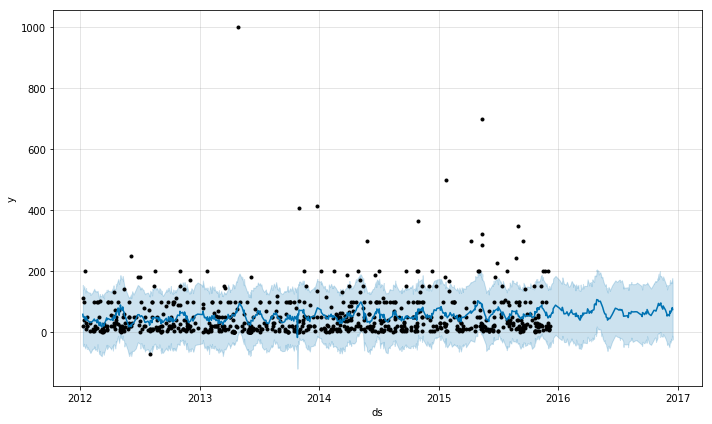

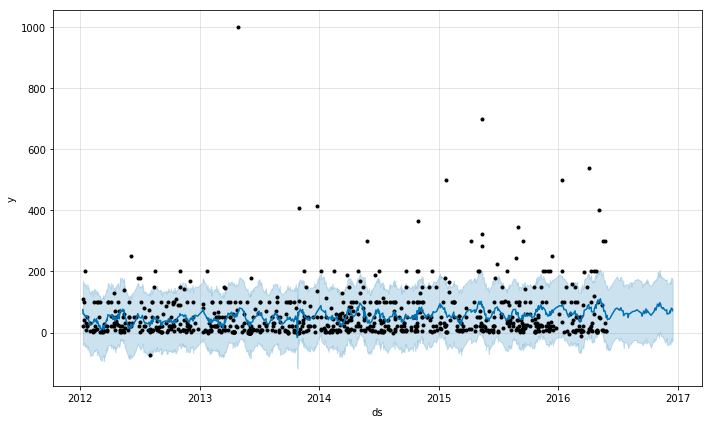

In [16]:
from fbprophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter('ignore')

tscv = TimeSeriesSplit(n_splits=10)
ds = np.array(df.ds.tolist())
y = np.array(df.y.tolist())
for train_idx, test_idx in tscv.split(ds):
    m = Prophet(yearly_seasonality=True, daily_seasonality=True)
    input_df = pandas.DataFrame()
    input_df['ds'] = ds[train_idx]
    input_df['y'] = y[train_idx]
    m.fit(input_df)
    future = pandas.DataFrame()
    future['ds'] = ds
    forecast = m.predict(future)
    m.plot(forecast)
    print(f"mse: {mean_squared_error(forecast['yhat'][test_idx], y[test_idx])}")
warnings.simplefilter('default')

## Gradient Boosting

In [17]:
import xgboost
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter('ignore')

tscv = TimeSeriesSplit(n_splits=10)

weekday = df.apply(lambda r: r['ds'].weekday(), axis=1)
month = df.apply(lambda r: r['ds'].month, axis=1)
year = df.apply(lambda r: r['ds'].year, axis=1)

weekday = np.array(weekday).reshape(-1, 1)
X = np.append(weekday, np.array(month).reshape(-1, 1), 1)
X = np.append(X, np.array(year).reshape(-1, 1), 1)

y = np.array(df.y.tolist()).reshape(-1, 1)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]
    
    model = xgboost.XGBRegressor()
    model.fit(X_train, Y_train)
    
    Y_pred = model.predict(X_test)
    
    print(f"mse: {mean_squared_error(Y_test, Y_pred)}")
    
warnings.simplefilter('default')

mse: 8992.35408267566
mse: 14875.38139537061
mse: 2049.547805829082
mse: 6125.603339433278
mse: 29621.871299419174
mse: 9139.224649584274
mse: 12852.273936595466
mse: 8118.4980485581
mse: 13438.670430749264
mse: 13251.01283531676
